In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import astropy as ast
import random
from astropy.io import fits

In [9]:
class SaltModel:
    
    v_com = 5 #km/s
    
    def __init__(self, r_in, r_out, sky_angle, v_r_out, v_r_in, v_phi, v_z, v_rand, z_rot_limit, seed):
        
        
        # Primary outflow shape parameters
        # ------------------------------------------------------------------------------------#
        self.r_in_min = r_in           #in AU
        self.r_out_min = r_out         #in AU
        self.sky_angle = sky_angle     #in rad
        random.seed(seed)
        
        #self.r_inner_angle = r_inner_angle
        #self.r_outer_angle = r_outer_angle
        # ------------------------------------------------------------------------------------#
        
        
        # Velocity parameters
        # ------------------------------------------------------------------------------------#
        self.v_r_out = v_r_out      #in km/s
        self.v_r_in = v_r_in
        self.v_z_base = v_z      #in km/s
        self.v_phi_base = v_phi  #in km/s
        self.v_random = v_rand   #in km/s
        # ------------------------------------------------------------------------------------#
        
        
        # Limitation parameters
        # ------------------------------------------------------------------------------------#
        self.z_rot_limit = z_rot_limit #in AU
        # ------------------------------------------------------------------------------------#
        
        

        
    ### Dimension Functions ###
    def r_inner(self, z):
        return self.r_in_min
    
    
    def r_outer(self, z):
        return self.r_out_min
    
    
    
    
    ### Sky to Outflow Coordinate Functions ###
    # Sky (visual) coordinates in [x, y, z] to Model (rotated) coordinates in [x_model, y_model, z_model] #
    # x-axis is line-of-sight axis, y-axis is RA axis, z-axis is DEC axis #
    def sky_to_model_coordinates(self, x_sky, y_sky, z_sky):
        x_model = x_sky
        y_model = y_sky * np.cos(self.sky_angle) - z_sky * np.sin(self.sky_angle)
        z_model = y_sky * np.sin(self.sky_angle) + z_sky * np.cos(self.sky_angle)
        return x_model, y_model, z_model
    
    
    # Model (rotated) coordinates in [x, y, z] to Outflow (cylindrical) coordinates in [r, phi, z] #
    def model_to_outflow_coordinates(self, x_model, y_model, z_model):
        r = np.sqrt(np.power(x_model, 2) + np.power(y_model, 2))
        phi = np.arctan2(y_model, x_model)
        return r, phi, z_model
    
    
    # Sky (visual) coordinates in [x, y, z] to Outflow (cylindrical) coordinates in [r, phi, z] #
    def sky_to_outflow_coordinates(self, x_sky, y_sky, z_sky):
        x_model, y_model, z_model = self.sky_to_model_coordinates(x_sky, y_sky, z_sky)
        r, phi, z = self.model_to_outflow_coordinates(x_model, y_model, z_model)
        return r, phi, z
    
    
    
    
    ### Outflow to Sky Coordinate Functions ###
    # Outflow (cylindrical) coordinates in [r, phi, z] to Model (rotated) coordinates in [x, y, z] #
    # x-axis is line-of-sight axis, y-axis is RA axis, z-axis is DEC axis #
    def outflow_to_model_coordinates(self, r, phi, z):
        x_model = r * np.cos(phi)
        y_model = r * np.sin(phi)
        z_model = z
        return x_model, y_model, z_model
    
    
    # Model (rotated) coordinates in [x_model, y_model, z_model] to Sky (visual) coordinates in [x, y, z] #
    def model_to_sky_coordinates(self, x_model, y_model, z_model):
        x_sky = x_model
        y_sky = y_model * np.cos(self.sky_angle) + z_model * np.sin(self.sky_angle)
        z_sky = - y_model * np.sin(self.sky_angle) + z_model * np.cos(self.sky_angle)
        return x_sky, y_sky, z_sky
    
    
    # Outflow (cylindrical) coordinates in [r, phi, z] to Sky (visual) coordinates in [x, y, z] #
    def outflow_to_sky_coordinates(self, r, phi, z):
        x_model, y_model, z_model = self.outflow_to_model_coordinates(r, phi, z)
        x_sky, y_sky, z_sky = self.model_to_sky_coordinates(x_model, y_model, z_model)
        return x_sky, y_sky, z_sky
    
    
    
    
    ### Model to Sky Velocity Vectors ###
    # Outflow (cylindrical) coordinates in [r, phi, z] to Model (rotated) coordinates in [x_model, y_model, z_model] #
    # Velocity components are in Model coordinates in [v_x_model, v_y_model, v_z_model] #
    def outflow_to_model_vectors(self, phi, v_r, v_phi, v_z):
        v_x_model = v_r * np.cos(phi) - v_phi * np.sin(phi)
        v_y_model = v_r * np.sin(phi) + v_phi * np.cos(phi)
        v_z_model = v_z
        return v_x_model, v_y_model, v_z_model
    
    
    # Model (rotated) coordinates in [x_model, y_model, z_model] to Sky (visual) coordinates in [x, y, z] #
    # Velocity components are in Sky coordinates in [x, y, z] #
    def model_to_sky_vectors(self, v_x_model, v_y_model, v_z_model):
        v_x_sky = v_x_model 
        v_y_sky = v_y_model * np.cos(self.sky_angle) - v_z_model * np.sin(self.sky_angle)
        v_z_sky = v_y_model * np.sin(self.sky_angle) + v_z_model * np.cos(self.sky_angle)
        return v_x_sky, v_y_sky, v_z_sky
    
    
    # Outflow (cylindrical) coordinates in [r, phi, z] to Sky (visual) coordinates in [x, y, z] #
    # Velocity components are in Sky coordinates in [x, y, z] #
    def outflow_to_sky_vectors(self, phi, v_r, v_phi, v_z):
        v_x_model, v_y_model, v_z_model = self.outflow_to_model_vectors(phi, v_r, v_phi, v_z)
        v_x_sky, v_y_sky, v_z_sky = self.model_to_sky_vectors(v_x_model, v_y_model, v_z_model)
        return v_x_sky, v_y_sky, v_z_sky
    
    
    def sky_vectors_location_magnitude(self, x, y, z):
        r, phi, z_prime = self.sky_to_outflow_coordinates(x, y, z)
        
        v_r = self.v_r_out * self.v_radial_dropoff(z_prime)
        v_phi = np.where(True, self.v_phi_base * self.v_phi_dropoff(r), 0.)
        v_z = np.where(z_prime > 0., self.v_z_base * self.v_z_dropoff(z_prime), -self.v_z_base * self.v_z_dropoff(z_prime))
        
        r_lim, phi_lim, z_lim, v_r_lim, v_phi_lim, v_z_lim = self.constrain_r_and_z(r, phi, z_prime, v_r, v_phi, v_z)
        
        x_lim, y_lim, z_lim = self.outflow_to_sky_coordinates(r_lim, phi_lim, z_lim)
        
        v_x_sky, v_y_sky, v_z_sky = self.outflow_to_sky_vectors(phi, v_r_lim, v_phi_lim, v_z_lim)
        
        v_x_sky = self.add_random_velocity_component(v_x_sky)
        v_y_sky = self.add_random_velocity_component(v_y_sky)
        v_z_sky = self.add_random_velocity_component(v_z_sky)
        
        
        return x_lim, y_lim, z_lim, v_x_sky, v_y_sky, v_z_sky
    
    
    def model_vectors_location_magnitude(self, x, y, z):
        r, phi, z_prime = self.model_to_outflow_coordinates(x, y, z)
        
        v_r = self.v_r_out * self.v_radial_dropoff(z_prime)
        v_phi = np.where(True, self.v_phi_base * self.v_phi_dropoff(r), 0.)
        v_z = np.where(z_prime > 0., self.v_z_base * self.v_z_dropoff(z_prime), -self.v_z_base * self.v_z_dropoff(z_prime))
        
        r_lim, phi_lim, z_lim, v_r_lim, v_phi_lim, v_z_lim = self.constrain_r_and_z(r, phi, z_prime, v_r, v_phi, v_z)
        
        x_lim, y_lim, z_lim = self.outflow_to_model_coordinates(r_lim, phi_lim, z_lim)
        
        v_x_mod, v_y_mod, v_z_mod = self.outflow_to_model_vectors(phi, v_r_lim, v_phi_lim, v_z_lim)
        
        v_x_mod = self.add_random_velocity_component(v_x_mod)
        v_y_mod = self.add_random_velocity_component(v_y_mod)
        v_z_mod = self.add_random_velocity_component(v_z_mod)
        
        return x_lim, y_lim, z_lim, v_x_mod, v_y_mod, v_z_mod
    
    
    
    def add_random_velocity_component(self, v):
        v_mutate = []
        for vel in np.nditer(v):
            v_mutate.append(vel + random.normalvariate(0.0, self.v_random))
        
        v_mutate = np.reshape(v_mutate, v.shape)
        return v_mutate
    
    
    def constrain_var_r_and_z(self, radius, phi, z_prime, var):
        mask = (radius > self.r_inner(z_prime)) & (radius < self.r_outer(z_prime)) & (np.abs(z_prime) < self.z_rot_limit)
        var_lim = np.where(mask, var, np.nan)
        
        return var_lim
    
    
    def constrain_r_and_z(self, radius, phi, z_prime, v_r, v_phi, v_z):
        mask = (radius > self.r_inner(z_prime)) & (radius < self.r_outer(z_prime)) & (np.abs(z_prime) < self.z_rot_limit)
        
        r_lim = np.where(mask, radius, np.nan)
        phi_lim = np.where(mask, phi, np.nan)
        z_lim = np.where(mask, z_prime, np.nan)
        v_r_lim = np.where(mask, v_r, np.nan)
        v_phi_lim = np.where(mask, v_phi, np.nan)
        v_z_lim = np.where(mask, v_z, np.nan)
        
        return r_lim, phi_lim, z_lim, v_r_lim, v_phi_lim, v_z_lim
    
    
    def signal_strength_outflow_coordinates(self, r, phi, z_prime, exp_factor, los):
        if los == "x" or los == "X":
            return self.x_los_signal_strength(r, phi, z_prime, exp_factor)
        elif los == "y" or los == "Y":
            return self.y_los_signal_strength(r, phi, z_prime, exp_factor)
        else:
            return false
        
        
    def signal_strength_sky_coordinates(self, x, y, z, exp_factor, los):
        r, phi, z_prime = self.sky_to_outflow_coordinates(x, y, z)
        
        if los == "x" or los == "X":
            return self.x_los_signal_strength(r, phi, z_prime, exp_factor)
        elif los == "y" or los == "Y":
            return self.y_los_signal_strength(r, phi, z_prime, exp_factor)
        else:
            return false
    
    
    def x_los_signal_strength(self, r, phi, z_prime, exp_factor):           
        
        x_model = r * np.cos(phi)
        y_model = r * np.sin(phi)
        z_model = z_prime
        
        r_inner = self.r_inner(z_prime)
        r_outer = self.r_outer(z_prime)
        
        x_sky = x_model
        y_sky = y_model * np.cos(self.sky_angle) - z_model * np.sin(self.sky_angle)
        z_sky = y_model * np.sin(self.sky_angle) + z_model * np.cos(self.sky_angle)
        
        signal_strength = np.zeros_like(y_model)
        
        x_model = self.constrain_var_r_and_z(r, phi, z_prime, x_model)
        y_model = self.constrain_var_r_and_z(r, phi, z_prime, y_model)
        
        x_l, y_l = y_model.shape
        
        for x in range(x_l):
            for y in range(y_l):
                if np.isnan(y_model[x, y]):
                    signal_strength[x, y] = np.nan
                else:
                    outer_cord_length = np.sqrt(np.abs(np.power(r_outer, 2) - np.power(y_model[x, y], 2)))

                    if np.abs(y_model[x, y]) < r_inner:
                        inner_cord_length = np.sqrt(np.abs(np.power(r_inner, 2) - np.power(y_model[x, y], 2)))

                        if x_model[x, y] > 0:
                            strength = -(outer_cord_length - x_model[x, y])
                            signal_strength[x, y] = np.exp(strength * exp_factor)
                        else:
                            strength = -(outer_cord_length - x_model[x, y] - inner_cord_length * 2)
                            signal_strength[x, y] = np.exp(strength * exp_factor)

                    else:
                        strength = -(outer_cord_length - x_model[x, y])
                        signal_strength[x, y] = np.exp(strength * exp_factor)
        
        return signal_strength 
    
    
    def y_los_signal_strength(self, r, phi, z_prime, exp_factor):  
        ### DOES NOT TAKE SKY ANGLE INTO ACCOUNT ###
        
        x_model = r * np.cos(phi)
        y_model = r * np.sin(phi)
        z_model = z_prime
        
        r_inner = self.r_inner(z_prime)
        r_outer = self.r_outer(z_prime)
        
        x_sky = x_model
        y_sky = y_model * np.cos(self.sky_angle) - z_model * np.sin(self.sky_angle)
        z_sky = y_model * np.sin(self.sky_angle) + z_model * np.cos(self.sky_angle)
        
        signal_strength = np.zeros_like(x_model)
        
        x_model = self.constrain_var_r_and_z(r, phi, z_prime, x_model)
        y_model = self.constrain_var_r_and_z(r, phi, z_prime, y_model)
        
        x_l, y_l = y_model.shape
        
        for y in range(y_l):
            for x in range(x_l):
                if np.isnan(x_model[x, y]):
                    signal_strength[x, y] = np.nan
                else:
                    outer_cord_length = np.sqrt(np.abs(np.power(r_outer, 2) - np.power(x_model[x, y], 2)))

                    if np.abs(x_model[x, y]) < r_inner:
                        inner_cord_length = np.sqrt(np.abs(np.power(r_inner, 2) - np.power(x_model[x, y], 2)))

                        if y_model[x, y] > 0:
                            strength = -((outer_cord_length) - y_model[x, y])
                            signal_strength[x, y] = np.exp(strength * exp_factor)
                        else:
                            strength = -((outer_cord_length) - y_model[x, y] - inner_cord_length * 2)
                            signal_strength[x, y] = np.exp(strength * exp_factor)
                        
                    else:
                        strength = -((outer_cord_length) - y_model[x, y])
                        signal_strength[x, y] = np.exp(strength * exp_factor)
        
        return signal_strength
        
        
            
        
        
    
    
    
    ### Velocity Field Functions ###
    # Outflow (cylindrical) coordinates in [r, phi, z] for every point in space created in model #
    def velocity_model_field(self, r, phi, z) :
        # Boolean filter to only keep valid r #
        # Velocity components will be numpy.nan outside the outflow shells #
        mask = (r > self.r_inner(z)) & (r < self.r_outer(z))
        
        # Constant radial expansion velocity #
        v_r = np.where(mask, self.v_r_out * self.v_radial_dropoff(z), np.nan)
        
        # Azimuthal rotation of vphi0 next to disk, drops linearly to 0 at height z_no_rotation #
        v_phi = np.where(z < self.z_rot_limit, self.v_phi_base * self.v_phi_dropoff(r), 0.)
        v_phi = np.where(mask, v_phi, np.nan)
        
        # Flows away from disk at constant velocity vz0
        v_z = np.where(z > 0., self.v_z_base * self.v_z_dropoff(z), -self.v_z_base * self.v_z_dropoff(z))
        v_z = np.where(mask, v_z, np.nan)
        return v_r, v_phi, v_z
    
    
    # Outflow velocity change rates #
    def v_radial_dropoff(self, z):
        return 1.
    
    
    def v_phi_dropoff(self, r):
        r = np.where(r > self.r_outer(self.r_out_min), r, np.nan)
        r_recip = np.reciprocal(r)
        dropoff = np.where(np.isnan(r_recip), 1.0, self.r_outer(self.r_out_min) * r_recip)
        return dropoff
    
    
    def v_z_dropoff(self, z):
        return 1.

    
    
    
    ### Density Function (for visualization) ###
    # this is a placeholder function to calculate density in the outflow coordinate system
    def density_outflow(self, r, phi, z) :
        mask = (r > self.r_inner(z)) & (r < self.r_outer(z)) & (np.abs(z) < self.z_rot_limit)
        density = np.where(mask, 1., np.nan)
        return density
    
    def density_model(self, x_model, y_model, z_model) :
        r, phi, z = self.model_to_outflow_coordinates(x_model, y_model, z_model)
        mask = (r > self.r_inner(z)) & (r < self.r_outer(z))
        density = np.where(mask, 1., np.nan)
        return density
    
    def density_sky(self, x, y, z) :
        r, phi, z = self.sky_to_outflow_coordinates(x, y, z)
        mask = (r > self.r_inner(z)) & (r < self.r_outer(z))
        density = np.where(mask, 1., np.nan)
        return density
    
    
    
    
    
    
    
    ### MAPS ###
    # position-velocity plot at projected distance z along outflow axis    
    def position_velocity(self, axis, exp_factor):
        def pv(ax, z, vmin, vmax, nvbins, axis, exp_factor):
            x, y = np.meshgrid( np.linspace(-150,150,501), np.linspace(-150,150,501) )
                # using 240 AU x 240 AU slices for this example
                # possible addition to the code is to check that outflow fits within the slice
            x_v, y_v, z_v, v_x, v_y, v_z = self.model_vectors_location_magnitude(x, y, z)
                # 2D [y,x] array of velocity vectors in plane z
                # we only care about vy, the velocity along the line of sight
            
            a_x = x * (206265.0 / 86218457.62)
            a_y = y * (206265.0 / 86218457.62)
                
            if axis == "x":
                v_y_adj = -1 * v_y + SaltModel.v_com
                # add the source VLSR
                vlos=[]
                for i in range(0,len(x)) :
                    vl,binedges = np.histogram(v_y_adj[:, i], range=(vmin, vmax), bins=nvbins)
                        # vy contains len(y) rows of len(x) columns; we are making a histogram in
                        # the y-direction for each x-position, vy[:,i]
                    vlos.append(vl)
                ax.imshow( vlos, origin='lower', aspect='auto', extent=(vmin, vmax, a_x[0,0], a_x[-1,-1]) )
                ax.annotate("z = %.0f AU" % z, (.05, .9), xycoords="axes fraction", color='white')
                
            elif axis == "y":
                v_x_adj = -1 * v_x + SaltModel.v_com
                # add the source VLSR
                vlos=[]
                for i in range(0,len(y)) :
                    vl,binedges = np.histogram(v_x_adj[i, :], range=(vmin, vmax), bins=nvbins)
                        # vy contains len(y) rows of len(x) columns; we are making a histogram in
                        # the y-direction for each x-position, vy[:,i]
                    vlos.append(vl)
                ax.imshow( vlos, origin='lower', aspect='auto', extent=(vmin, vmax, a_y[0,0], a_y[-1,-1]) )
                ax.annotate("z = %.0f AU" % z, (.05, .9), xycoords="axes fraction", color='white')
            else:
                return false;


        # make a grid of 9 position-velocity plots at intervals z_step along outflow axis
        nx = 3
        ny = 3
        fig, ax = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10,9))

        z = 0.
        z_step = 1.
            # z starting value and step size in AU

        vmin = SaltModel.v_com - 30.
        vmax = SaltModel.v_com + 30.
        nvbins = 41
            # set velocity range and resolution

        for i in range(0, nx) :
            for j in range(0, ny) :
                pv(ax[i, j], z, vmin, vmax, nvbins, axis, exp_factor)
                if i == nx - 1 :
                    ax[i, j].set_xlabel("VLSR (km/sec)")
                if j == 0 :
                    ax[i, j].set_ylabel(axis + " offset (AU)")
                z += z_step

        plt.tight_layout()
        plt.show()
        
        
        
        
    def channel_maps(self, vmin, vmax, nvchans, size, haxis):

        # make sure that y-grid encompasses entire (tilted) outflow lobe along line of sight
        # number of x, z pixels sets spatial resolution, number of y pixels sets velocity resolution
        x, y, z = np.meshgrid(np.linspace(-125, 125, size + 1), np.linspace(-125, 125, size + 1), np.linspace(-125, 125, size + 1))

        
        a_x = x * (206265.0 / 86218457.62)
        a_y = y * (206265.0 / 86218457.62)
        a_z = z * (206265.0 / 86218457.62)

        x_v, y_v, z_v, v_x, v_y, v_z = self.sky_vectors_location_magnitude(x, y, z)
        
        
        if (haxis == "y"):
            v_y = -v_y
            v_y_adj = v_y + SaltModel.v_com

            # each spectrum in this 1d list corresponds to a single pixel in the sky
            spectrum_list = []
            for i in range(0, z.shape[2]) :
                for j in range(0, x.shape[1]) :
                    vl,binedges = np.histogram( v_y_adj[:,j,i], range=(vmin, vmax), bins=nvchans)
                    spectrum_list.append(vl)
            chanmaps = np.reshape(spectrum_list, (z.shape[2], x.shape[1], nvchans))
            
        elif (haxis == "x"):
            v_x = -v_x
            v_x_adj = v_x + SaltModel.v_com

            # each spectrum in this 1d list corresponds to a single pixel in the sky
            spectrum_list = []
            for i in range(0, z.shape[2]) :
                for j in range(0, y.shape[0]) :
                    vl,binedges = np.histogram( v_x_adj[j,:,i], range=(vmin, vmax), bins=nvchans)
                    spectrum_list.append(vl)
            chanmaps = np.reshape(spectrum_list, (z.shape[2], y.shape[0], nvchans))
            
        else:
            return false



        # plot grid of channel maps
        ncols = 4
        nrows = int(nvchans/ncols)
        if ncols * nrows < nvchans :
            nrows += 1
        fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10,10), \
                                 squeeze=False)
        for nplot in range(0, nvchans) :
            vcenter = (binedges[nplot] + binedges[nplot+1])/2.
            
            if (haxis == "x"):
                ax[int(nplot/ncols), nplot%ncols].imshow(np.flip(chanmaps[:,:,nplot], 1), origin='lower', \
                            extent=(a_y[0,0,0], a_y[-1,0,0], a_z[0,0,0], a_z[0,0,-1]), aspect=1)
                
                
            elif (haxis == "y"):
                ax[int(nplot/ncols), nplot%ncols].imshow(np.flip(chanmaps[:,:,nplot], 0), origin='lower', \
                            extent=(a_x[0,0,0], a_x[0,-1,0], a_z[0,0,0], a_z[0,0,-1]), aspect=2)
                
            
            
            ax[int(nplot/ncols), nplot%ncols].annotate("%.1f" % vcenter, (.05,.9), \
                            color='white', xycoords='axes fraction', fontsize=16)
        plt.tight_layout()
        plt.show()

        return chanmaps

In [10]:
# Adjust these parameters to control the shape of the outflow lobes
# r = r0 + r1 * abs(z) + r2 * sqrt(abs(z)); units = AU
# ----------------------------------------------------------------------------------------------#
r_inner_base = 50.0                      # inner radius at base of outflow from the circumstellar disk
r_outer_base = 60.0                     # outer radius at base of outflow from the circumstellar disk
theta = math.radians(50.)             # angle of outflow axis to plane of sky 
# ----------------------------------------------------------------------------------------------#


# Test and Deprecated Variables
# ----------------------------------------------------------------------------------------------#
#r_inner_angle = math.atan(.25)        # angle relating linear increase in inner radius with z
#r_outer_angle = math.atan(.50)        # angle relating linear increase in outer radius with z
#theta = 0                             # test angle of outflow axis to plane of sky 
# ----------------------------------------------------------------------------------------------#



# Adjust these parameters to control the velocity field inside the outflow shells
# ----------------------------------------------------------------------------------------------#
v_radial_0 = 0.         # radial expansion speed at all z
v_phi_0 = 15.0            # rotational velocity at zprime=0 (in the disk)
v_z_0 = 0.0             # expansion speed along outflow axis
z_no_rotation = 10.   # rotataional velocity drops to 0 at height z_no_rotation (AU)
# ----------------------------------------------------------------------------------------------#

# Randomness Parameters
# ----------------------------------------------------------------------------------------------#
seed = 510920758332
v_rand = 5
# ----------------------------------------------------------------------------------------------#




### Create model instance with parameters above ###
model_instance = SaltModel(r_inner_base, r_outer_base, theta, v_radial_0, v_radial_0, v_phi_0, v_z_0, v_rand, z_no_rotation, seed)



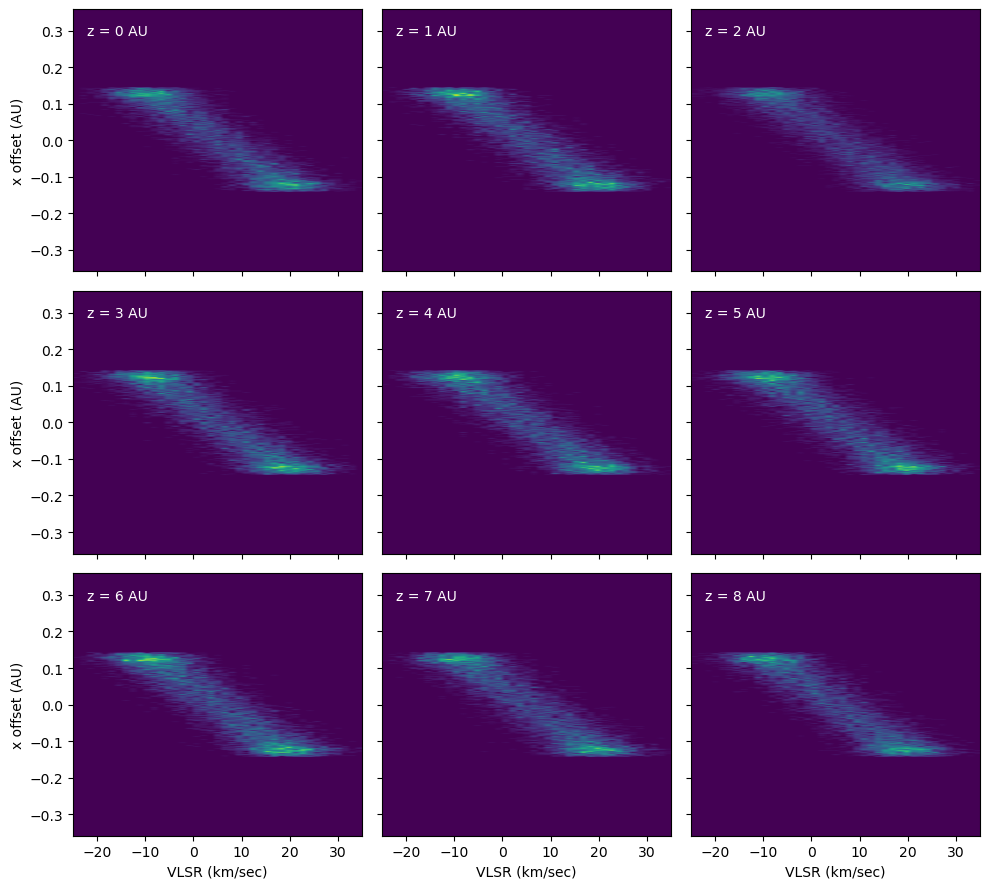

In [11]:
model_instance.position_velocity("x", 0.01)

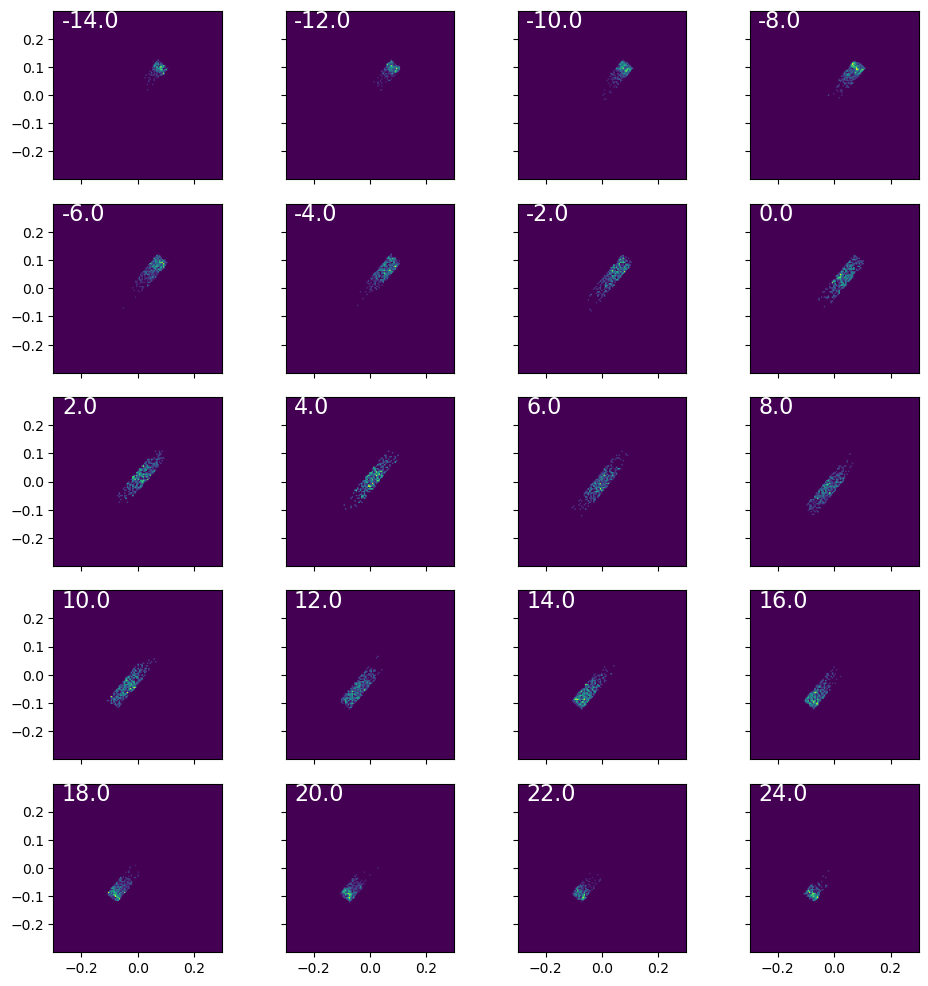

In [12]:
###-50 to 50 AU
x_chan_maps = model_instance.channel_maps(-15., 25., 20, 125, "x")